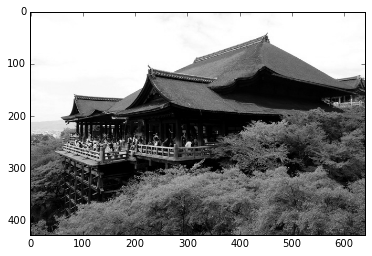

In [174]:
from PIL import Image
from numpy import *
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

img = array(Image.open("C:/Users/BIG DATA/imgs/stage.jpg").convert("L"))

# pil_im = Image.fromarray(img)
# pil_im = Image.fromarray(uint8(img))
plt.imshow(img,'gray')
plt.show()

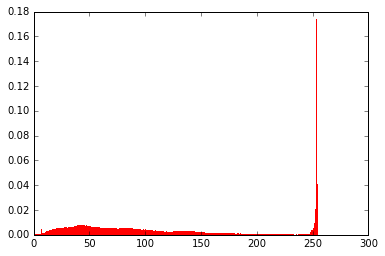

In [144]:
from skimage import data
import matplotlib.pyplot as plt
plt.figure("hist")
arr=img.flatten()
n, bins, patches = plt.hist(arr, bins=256, normed=1,edgecolor='None',facecolor='red')  
plt.show()

In [139]:
def drawBinary(img, T):
    biImg = img*0
    i = 0
    for rPix in img:
        j = 0
        for pix in rPix:
            if pix >= T:
                biImg[i,j] = 255
            else:
                biImg[i,j] = 0
            j += 1
        i += 1
    plt.imshow(biImg,'gray')
    plt.show()
    return biImg

# 1. 平均值法
### 以整張圖的平均灰度作為門閥值

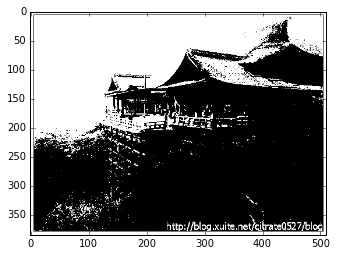

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [142]:
import numpy as np
def GetMeanThreshold(img):
    HistGram = img.flatten()
    Amount = 0
    Sum = 0
    for Y in range(0,256):
        Amount = Amount + HistGram[Y]
        Sum = Sum + Y * HistGram[Y]
    return Sum / Amount
# 直接繪出
Threshold = GetMeanThreshold(img)
drawBinary(img,Threshold)

# 2. P-Tile 方法
##### Doyle於1962年提出的P-Tile (即P分位數法)可以說是最古老的一種閾值選取方法。該方法根據先驗概率來設定閾值，使得二值化後的目標或背景像素比例等於先驗概率，該方法簡單高效，但是對於先驗概率難於估計的圖像卻無能為力。

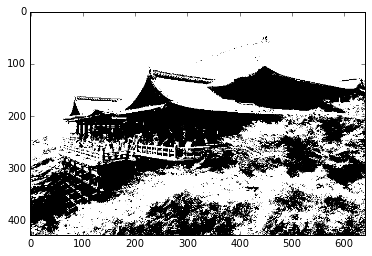

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255,   0, 255, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [255, 255,   0, ..., 255, 255,   0]], dtype=uint8)

In [183]:
# HistGram 灰度图像的直方图
# Tile 背景在图像中所占的面积百分比
def GetPTileThreshold(img, Tile):
    HistGram = img.flatten()
    Amount = 0
    Sum = 0
    for Y in range(0,256):
        Amount += HistGram[Y]
    for Y in range(0,256):
        Sum = Sum + HistGram[Y]
        if Sum >= Amount * Tile / 100:
            return Y
    return -1
Threshold = GetPTileThreshold(img,30) #Tile 其實要用利用先驗概率來設定，不過這個不事主軸就不多解釋。
drawBinary(img,Threshold)

# 3. 以谷底最小值為門閥值
####     此方法用在有明顯雙峰(統計分配)，其尋找雙峰的谷底作為閾值，但是該方法不一定能獲得閾值，對於那些具有平坦的直方圖或單峰圖像，該方法不合適。

####     參考論文:
J. M. S. Prewitt and M. L. Mendelsohn, "The analysis of cell images," innnals of the New York Academy of Sciences, vol. 128, pp. 1035-1053, 1966.
C. A. Glasbey, "An analysis of histogram-based thresholding algorithms," CVGIP: Graphical Models and Image Processing, vol. 55, pp. 532-537, 1993.


尋找雙峰圖片中...

In [145]:
def IsDimodal(HistGram): #檢測直方圖是否為雙峰
    #對直方圖的峰進行計數，只有峰數位2才為雙峰
    Count = 0;
    for Y in range(1,255):
        if HistGram[Y - 1] < HistGram[Y]:
            if HistGram[Y + 1] < HistGram[Y]:
                Count += 1
                if Count > 2:
                    return False
        if Count == 2:
            return True
        else:
            return False

-1


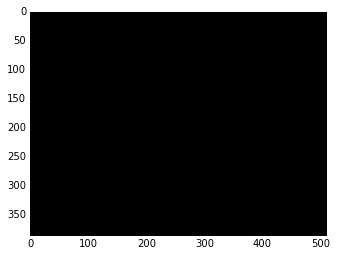

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [149]:
def GetMinimumThreshold(img):
    HistGram = img.flatten()
    Y = 0
    Iter = 0
    HistGramC = [0.0]*256  #基於精度問題，一定要用浮點數來處理，否則得不到正確的結果。
    HistGramCC = [0.0]*256 #計算過程會破壞原來數值，因此複製兩份。
    for Y in range(0,256):
        HistGramC[Y] = HistGram[Y]
        HistGramCC[Y] = HistGram[Y]
    #通過三點求均值來平滑直方圖
    while IsDimodal(HistGramC) == False:
        HistGramCC[0] = (HistGramC[0] + HistGramC[0] + HistGramC[1]) / 3;                 #第一點
        for Y in range(1,255):
            HistGramCC[Y] = (HistGramC[Y - 1] + HistGramC[Y] + HistGramC[Y + 1]) / 3;     #中間的點
        HistGramCC[255] = (HistGramC[254] + HistGramC[255] + HistGramC[255]) / 3;         #最後一點
        for copyIndex in range(0,256):
            HistGramC[copyIndex] = HistGramCC[copyIndex]
        Iter += 1
        if Iter >= 1000:
            return -1
    #門閥值為兩峰中間最小值
    Peakfound = False
    for Y in range(1,255):
        if HistGramCC[Y - 1] < HistGramCC[Y] and HistGramCC[Y + 1] < HistGramCC[Y]:
            Peakfound = True
            
        if Peakfound == True and HistGramCC[Y - 1] >= HistGramCC[Y] and HistGramCC[Y + 1] >= HistGramCC[Y]:
            return Y - 1
    return -1

# 4. 以雙峰平均值為閥值
#### 該演算法和以谷底最小值的閾值方法類似，只是最後一步不是取得雙峰之間的谷底值，而是取雙峰的平均值作為閾值。

In [ ]:
def GetIntermodesThreshold(HistGram):
    HistGram = img.flatten()
    Y = 0
    Iter = 0
    HistGramC = [0.0]*256  #基於精度問題，一定要用浮點數來處理，否則得不到正確的結果。
    HistGramCC = [0.0]*256 #計算過程會破壞原來數值，因此複製兩份。
    for Y in range(0,256):
        HistGramC[Y] = HistGram[Y]
        HistGramCC[Y] = HistGram[Y]
    #通過三點求均值來平滑直方圖
    while IsDimodal(HistGramC) == False:
        HistGramCC[0] = (HistGramC[0] + HistGramC[0] + HistGramC[1]) / 3;                 #第一點
        for Y in range(1,255):
            HistGramCC[Y] = (HistGramC[Y - 1] + HistGramC[Y] + HistGramC[Y + 1]) / 3;     #中間的點
        HistGramCC[255] = (HistGramC[254] + HistGramC[255] + HistGramC[255]) / 3;         #最後一點
        for copyIndex in range(0,256):
            HistGramC[copyIndex] = HistGramCC[copyIndex]
        Iter += 1
        if Iter >= 1000: #真的找不到雙峰
            return -1

#閾值為兩峰值的平均值
    Peak = []
    Index = 0
    for Y in range(0,255):
        if HistGramCC[Y - 1] < HistGramCC[Y] and HistGramCC[Y + 1] < HistGramCC[Y]:
            Peak[Index] = Y - 1
            Index += 1
        return (Peak[0] + Peak[1]) / 2

# 5. 跌代最佳閥值
####  該算法先假定一個閾值，然後計算在該閾值下的前景和背景的中心值，當前景和背景中心值得平均值和假定的閾值相同時，則迭代中止，並以此值為閾值進行二值化。

126


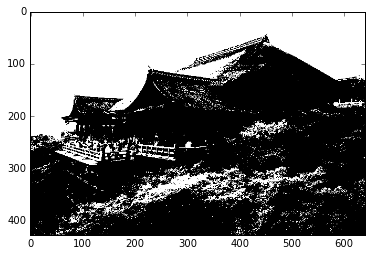

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [188]:
def GetIterativeBestThreshold(img):
    HistGram = img.flatten()
    X =0
    Iter = 0
    MinValue = 0
    MaxValue = 255
    for Min in range(0,256):
        if HistGram[Min] == 0:
            MinValue += 1
    for Max in range(255, MinValue):
        if HistGram[MinValue] == 0:
            MaxValue -= 1
    if MaxValue == MinValue:       #只有一個顏色
        return MaxValue
    if MinValue + 1 == MaxValue:   #只有兩個顏色
        return MinValue
    Threshold = MinValue
    NewThreshold = (MaxValue + MinValue) / 2
    while Threshold != NewThreshold:    #兩次跌代值相同, 擇結束跌代   
        SumOne = 0
        SumIntegralOne = 0
        SumTwo = 0
        SumIntegralTwo = 0
        Threshold = NewThreshold
        for X in range(MinValue, Threshold):   #根據閾值將圖像分割成目標和背景兩部分，求出兩部分的平均灰度值
            SumIntegralOne += HistGram[X] * X
            SumOne += HistGram[X]
        MeanValueOne = SumIntegralOne / SumOne
        for X in range(Threshold+1, MaxValue):
            SumIntegralTwo += HistGram[X] * X
            SumTwo += HistGram[X]
        MeanValueTwo = SumIntegralTwo / SumTwo
        NewThreshold = (MeanValueOne + MeanValueTwo) / 2     #新的閾值
        Iter += 1
        if Iter >= 1000:
            return -1
    return Threshold

Threshold = GetIterativeBestThreshold(img)
print Threshold
drawBinary(img,Threshold)

# 6. OSTU大津法
#### 該算法是1979年由日本大津提出的，主要構想是取某個閾值，使得前景和背景兩類的類間方差最大，matlab中的graythresh即是以該算法為原理執行的。

In [193]:
import cv  
  
def OtsuGray( grayImage ,debug = 0):  
    # 如果圖片是Map對象,則轉換為Image對象 
    if type(grayImage) == cv.cvmat:  
        grayImage = cv.GetImage(grayImage)  
        
    hist = cv.CreateHist([256],cv.CV_HIST_ARRAY,[[0,256]])  #Hist
    cv.ClearHist(hist)
    cv.CalcHist([grayImage],hist)
    # 開始計算
    # 計算總亮度  
    totalH = 0  
    for h in range(0,256):  
        v = cv.QueryHistValue_1D(hist,h)  
        if v == 0 : continue  
        totalH += v*h  
        if debug > 3 : print "t=%d,%d,%d"%(h,totalH,v*h)  
          
  
    width  = grayImage.width  
    height = grayImage.height  
    total  = width*height  
      
    if debug > 1 : print "總素相:%d;總亮度:%平均亮度:%0.2f"%(total,totalH,totalH/total)  
  
    # t=0和t=255的時候無法分割，所以從t=1開始計算一致到t=255  
    v = 0  
    gMax = 0.0  
    tIndex = 0  
    # temp  
    n0Acc = 0  
    n1Acc = 0  
    n0H   = 0  
    n1H   = 0  
    for t in range(1,255):  
        v = cv.QueryHistValue_1D(hist,t-1)  
        if v == 0: continue  
          
        n0Acc += v          #灰度小於t的像素數目  
        n1Acc = total - n0Acc #灰度大於等於t的像素數目  
        n0H += (t-1)*v          #灰度小於t的像素總亮度 
        n1H = totalH - n0H  #灰度大於等於t的像素總亮度

        if n0Acc > 0 and n1Acc > 0:  
            u0 = n0H/n0Acc # 灰階小於t的平均灰度  
            u1 = n1H/n1Acc # 灰階大於等於t的平均灰度 
            w0 = n0Acc/total # 灰階小於t的像素比例
            w1 = 1.0-w0      # 灰階大於等於t的像素比例
            uD = u0-u1  
            g = w0 * w1 * uD * uD  
  
            if debug > 2: print "t=%3d; u0=%.2f,u1=%.2f,%.2f;n0H=%d,n1H=%d; g=%.2f"%(t,u0,u1,u0*w0+u1*w1,n0H,n1H,g)  
  
            if gMax < g:  
                gMax   = g  
                tIndex = t  
          
    if debug >0 : print "gMaxValue=%.2f; t = %d ; t_inv = %d"%(gMax,tIndex,255-tIndex)              
  
    return tIndex  

Threshold = OtsuGray(img)
print Threshold
drawBinary(img,Threshold)

AttributeError: 'numpy.ndarray' object has no attribute 'width'